## Berlin Aribnb 2015-2019

The data was obtained from Inside Airbnb (http://insideairbnb.com/get-the-data.html). 

With this data, I am interested in answering these few questions as follow:

    1. Did the price increase in the last several years?    
    2. Is it more expensive to stay on the weekend?   
    3. Location, location, location? - What neighbourhood groups are the most expensive ones to stay in Berlin?   
    4. Can we predict the price using the availabe data?

To get started, let's first import the necessary libraries and read in the dataset from July 2019 to see how it looks like.

In [72]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from datetime import datetime as dt
import calendar
%matplotlib inline

path = './berlin_airbnb/2019-07-11/listings_summary.csv'

berlin_201707 = pd.read_csv(path)

berlin_201707.head()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,1944,cafeheaven Pberg/Mitte/Wed for the summer 2019,2164,Lulah,Mitte,Brunnenstr. Nord,52.54425,13.39749,Private room,21,120,18,2018-11-11,0.25,1,364
1,2015,Berlin-Mitte Value! Quiet courtyard/very central,2217,Jan,Mitte,Brunnenstr. Süd,52.53454,13.40256,Entire home/apt,60,4,126,2019-07-04,3.18,4,0
2,3176,Fabulous Flat in great Location,3718,Britta,Pankow,Prenzlauer Berg Südwest,52.53500,13.41758,Entire home/apt,90,62,145,2019-06-27,1.18,1,279
3,3309,BerlinSpot Schöneberg near KaDeWe,4108,Jana,Tempelhof - Schöneberg,Schöneberg-Nord,52.49885,13.34906,Private room,28,7,27,2019-05-31,0.38,1,284
4,6883,Stylish East Side Loft in Center with AC & 2 b...,16149,Steffen,Friedrichshain-Kreuzberg,Frankfurter Allee Süd FK,52.51171,13.45477,Entire home/apt,125,3,124,2018-10-18,1.08,1,0


By looking at the above table, I got some ideas of how to use the data to answer my above-mentioned questions. For example, I could use the compiling dates to analyze how the price changed with different days of the week, months, and years. 

To be able to do this, we need to add a few columns to indicate these different time frames. Now let's read in the files and concatenate them into a single dataframe, with the discussed columns added accordingly.

In [73]:
date_compiled_all = ['2015-10-03', '2015-11-08', '2015-12-05', '2016-01-04', '2016-02-04', '2016-04-04', '2016-05-03', \
                    '2016-06-03', '2016-07-05', '2016-08-04', '2016-09-05', '2016-10-04', '2016-11-07', '2016-12-08', \
                    '2017-01-06', '2017-02-10', '2017-03-06', '2017-04-08', '2017-05-08', '2018-04-12', '2018-05-14', \
                    '2018-06-09', '2018-07-10', '2018-08-14', '2018-09-12', '2018-10-10', '2018-11-07', '2018-12-10', \
                    '2019-01-14', '2019-02-06', '2019-03-08', '2019-04-11', '2019-05-14', '2019-06-08', '2019-07-11']
pieces = []
    
for date in date_compiled_all:
    
    path = './berlin_airbnb/%s/listings_summary.csv' % date

    frame = pd.read_csv(path)

    # Create a new column 'time' and parse the time to a 'date' column, parse the 'date' to a 'weekday' column,  
    # and finally extract the 'month' and 'year' periods, respectively.  
    
    frame['time'] = date
    
    frame['date'] = dt.strptime(date, '%Y-%m-%d')
    frame['weekday'] =  frame['date'].apply(lambda d: d.strftime('%A'))
    frame['month'] = pd.to_datetime(frame['time'], format='%Y-%m-%d').dt.to_period('M')
    frame['year'] = pd.to_datetime(frame['time'], format='%Y-%m-%d').dt.to_period('Y')
    
    # Drop the 'time' column as it's not needed for the future analysis
    frame = frame.drop(['time'], axis=1)

    pieces.append(frame)

df = pd.concat(pieces, axis=0, ignore_index=True)


df.tail()

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,date,weekday,month,year
711862,36592458,Artist apartment in quiet Kreuzberg,37122389,Daria,Friedrichshain-Kreuzberg,Tempelhofer Vorstadt,52.48900,13.37806,Entire home/apt,70,5,0,NaN,NaN,1,9,2019-07-11,Thursday,2019-07,2019
711863,36593139,Luxurious design loft in Berlin center,103315825,James,Pankow,Prenzlauer Berg Süd,52.52922,13.42470,Entire home/apt,185,3,0,NaN,NaN,2,173,2019-07-11,Thursday,2019-07,2019
711864,36596567,2 Zimmer in Schöneberg,186832416,Horst,Tempelhof - Schöneberg,Schöneberg-Süd,52.48815,13.35953,Private room,30,1,0,NaN,NaN,3,3,2019-07-11,Thursday,2019-07,2019
711865,36597559,Gorgeous Dwelling,102192493,Dewi,Friedrichshain-Kreuzberg,Südliche Friedrichstadt,52.49611,13.41825,Entire home/apt,90,2,0,NaN,NaN,2,60,2019-07-11,Thursday,2019-07,2019
711866,36599333,2-bedroom apartment in trendy neighbourhood,20718415,Ricardo,Neukölln,Reuterstraße,52.49327,13.42618,Entire home/apt,40,30,0,NaN,NaN,1,52,2019-07-11,Thursday,2019-07,2019


In [74]:
# Get the number of rows and columns in the dataset
df.shape

(711867, 20)

In [75]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 711867 entries, 0 to 711866
Data columns (total 20 columns):
id                                711867 non-null int64
name                              710813 non-null object
host_id                           711867 non-null int64
host_name                         708646 non-null object
neighbourhood_group               711867 non-null object
neighbourhood                     711867 non-null object
latitude                          711867 non-null float64
longitude                         711867 non-null float64
room_type                         711867 non-null object
price                             711867 non-null int64
minimum_nights                    711867 non-null int64
number_of_reviews                 711867 non-null int64
last_review                       569838 non-null object
reviews_per_month                 569758 non-null float64
calculated_host_listings_count    711867 non-null int64
availability_365                  711

In [76]:
# Now let's have a look at how many columns are there without missing values.
df.isnull().mean() == 0

id                                 True
name                              False
host_id                            True
host_name                         False
neighbourhood_group                True
neighbourhood                      True
latitude                           True
longitude                          True
room_type                          True
price                              True
minimum_nights                     True
number_of_reviews                  True
last_review                       False
reviews_per_month                 False
calculated_host_listings_count     True
availability_365                   True
date                               True
weekday                            True
month                              True
year                               True
dtype: bool

We can see that only columns including name, host_name, last_review, and reviews_per_month have missing values. For now I will leave them as they are and go on with analyzing the data, because I am not using these columns for the first few questions I am interested in answering. 

In [77]:
df.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,7.118670e+05,7.118670e+05,711867.000000,711867.000000,711867.000000,711867.000000,711867.000000,569758.000000,711867.000000,711867.000000
mean,1.217039e+07,4.122724e+07,52.509821,13.406340,62.510114,5.520919,14.958055,1.095925,2.058622,105.935000
std,8.422869e+06,4.949753e+07,0.030579,0.056985,153.917168,33.280345,31.920268,1.370438,7.476178,133.270198
min,1.944000e+03,1.581000e+03,52.344518,13.083888,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,5.527978e+06,7.334943e+06,52.489143,13.376937,31.000000,1.000000,1.000000,0.220000,1.000000,0.000000
50%,1.024431e+07,2.301886e+07,52.508940,13.417117,47.000000,2.000000,4.000000,0.590000,1.000000,24.000000
75%,1.818744e+07,5.123202e+07,52.532576,13.439031,70.000000,4.000000,13.000000,1.430000,1.000000,224.000000
max,3.659933e+07,2.749825e+08,52.661829,13.760739,9017.000000,5000.000000,559.000000,94.000000,250.000000,365.000000


The mean of minimum_nights is about 5.5, there is about 1 reviews_per_month on average, and the average price per night is about 62 euros, ranging from zero to 9017 euros! However, we shall take a closer look at the price.

### Q1. Did the price increase in the last several years? 
When talking about rentals, one of the most important considerations is the price. For example, how did the price change in the last few years? Does the price show a general trend over different months in a year?

In [78]:
# Now we can start aggregating the data at the room type and year using either groupby or pivot_table. 
# Here I will use pivot_table for the sake of readability.
price_yearly = df.pivot_table('price', index='year', columns='room_type', aggfunc='mean')
price_yearly

room_type,Entire home/apt,Private room,Shared room
year,,,
2015,74.229897,37.423973,32.557070
2016,76.544021,37.858091,31.368439
2017,78.774384,38.101972,32.753890
2018,80.578817,46.500534,44.572298
2019,85.000677,53.613534,58.196963


In [79]:
# Price change rate for entire home/apt
(85.000677 - 74.229897) / 74.229897

0.1451002956396397

Having seen that the price increased with time in the last few years, I wonder if it was due to shortened supply or not, as goes the Law of Supply and Demand "Low supply and high demand increase price and vice versa." Here I will use the amount of host_id as a proxy of the supply. 

In [80]:
supply_year = df.pivot_table('host_id', index='year', columns='room_type', aggfunc='count')
supply_year

room_type,Entire home/apt,Private room,Shared room
year,,,
2015,29087,17895,587
2016,96386,81193,2877
2017,49398,48082,1414
2018,108720,107677,2628
2019,81215,82535,2173


Supply has increased drastically from 2015 to 2019. Now visualize the monthly dynamics of the prices along with the supply during 2015-2019 to take a closer look.

In [81]:
price_monthly = df.pivot_table('price', index='month', columns='room_type', aggfunc='mean')
supply_monthly = df.pivot_table('host_id', index='month', columns='room_type', aggfunc='count')

Text(0.5, 0, 'Time period')

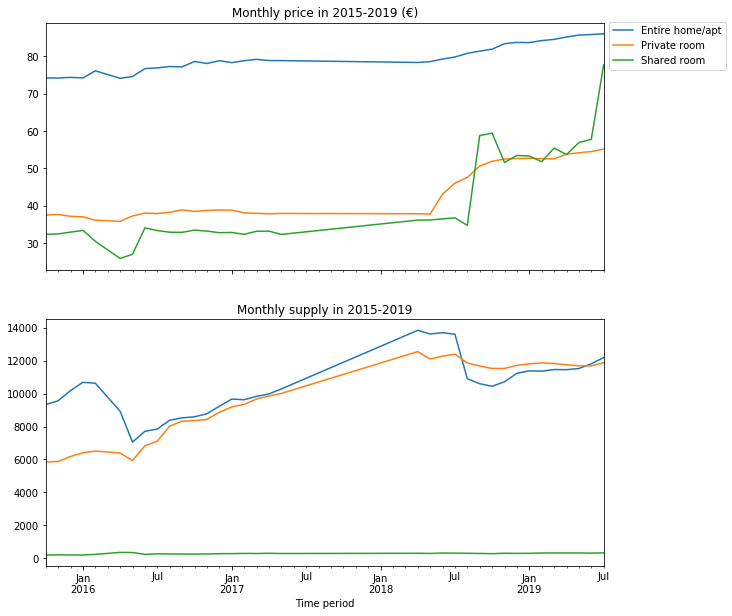

In [82]:
fig, axes = plt.subplots(2, 1)
price_monthly.plot(ax=axes[0], legend=False, sharex=True, title='Monthly price in 2015-2019 (€)', figsize=(10, 10))
supply_monthly.plot(ax=axes[1], legend=False, sharex=True, title='Monthly supply in 2015-2019', figsize=(10, 10))
plt.legend(loc=(1.01, 2.01))
plt.xlabel('Time period')


As expected, entire homes/apartments were more expensive than private rooms and shared rooms. Note that shared rooms got as expensive as private rooms since August 2018. 

The price for each of the three room types experienced an increase from 2016 to 2019, and this is especially true for shared rooms, for which the price almost doubled in the last four years.  

Both private rooms and shared rooms started to become more expensive from the second half of 2018. Note that there was again a sharp increase in July 2019 for shared rooms.

On the other hand, entire home/apartments saw the least price increase (15%) from 2015 to 2019.

The absolute majority of supply is focused on entire homes/apts and private rooms, with shared rooms having only relatively negligible supply.

A sudden drop in the supply was observed almost simultaneously with an increase in the prices of entire homes/apts and private rooms. The Law of Supply and Demand is working?!

Shared rooms seem to have more fluctuations compared to the other two room types especially since the beginning of 2019. 

### Q2. Is it more expensive to stay on the weekend?
Another interesting question is how the price changes with different days in a week. For people with flexible work time, this information might be able to help them decide on which weekdays they should travel in order to get better deals on Aiebnb.

In [83]:
price_weekday = df.pivot_table('price', index='weekday', columns='room_type', aggfunc='mean')
price_weekday

room_type,Entire home/apt,Private room,Shared room
weekday,,,
Friday,79.937908,42.837052,39.404719
Monday,78.776931,41.925158,37.123432
Saturday,78.812765,43.341623,39.540895
Sunday,74.145875,37.637802,32.439394
Thursday,80.498281,44.441400,45.582640
Tuesday,79.919908,44.974825,37.121041
Wednesday,82.721177,51.883221,55.203098


Text(0, 0.5, 'Price')

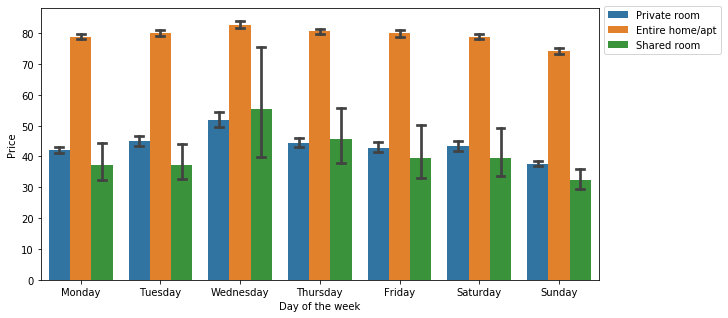

In [84]:
# Now let's visualize the price oof different room types on different days of the week
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=df['weekday'], y=df['price'], hue=df['room_type'], capsize=.1, linewidth=2.5,\
            order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.legend(loc=(1.01, 0.83))
plt.xlabel('Day of the week')
plt.ylabel('Price')

It turns out Sundays actually tend to be the cheapest for all three room types, whereas Wednesdays and Thusdays seem to be the most expensive in the week. This trend is especially obvious for private rooms and shared rooms. 

On Wednesdays, some shared rooms get even more expensive than private rooms. Note that the error bars show that the differences among different days are not always statistically significant. 

Again, shared rooms showed the largest fluctuations over the week. 

### Q3. Location, location, location?
Now that we have seen the price variations over time, let's take a look at how different neighbourhood groups impact the room prices.

In [85]:
# Number of neighbourhood groups included in the dataset
len(set(df['neighbourhood_group'].values))

12

In [86]:
# Highlight the maximun price of the neighbourhood_group, grouped by room_type and year 
loc_year = df.pivot_table('price', index='neighbourhood_group', columns=['room_type', 'year'], aggfunc='mean')
def highlight_max(s):
    '''
    highlight the maximum in a Series yellow.
    '''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]
loc_year.style.apply(highlight_max, axis=0)

In [87]:
# The above table has a lot of information and is hard to read, so I would seperate the year and room_type factors \
# into two different tables for the sakr of readability.

In [88]:
# Price of neighbourhood_group grouped by room_type
loc_room_type = df.pivot_table('price', index='neighbourhood_group', columns=['room_type'], aggfunc='mean')
cm = sns.light_palette('green', as_cmap=True)

loc_room_type.style.background_gradient(cmap=cm)

room_type,Entire home/apt,Private room,Shared room
neighbourhood_group,,,
Charlottenburg-Wilm.,94.4665,84.6473,35.0913
Friedrichshain-Kreuzberg,78.6773,41.3629,36.3602
Lichtenberg,67.4713,47.6176,31.4561
Marzahn - Hellersdorf,73.9612,36.7325,18.0041
Mitte,91.9041,40.2703,34.4809
Neukölln,62.7479,34.0311,35.4252
Pankow,79.2866,43.3189,95.6356
Reinickendorf,60.7563,33.2756,46.6468
Spandau,81.9393,36.1208,43.234


In [89]:
# Price of neighbourhood_group grouped by year
loc_year = df.pivot_table('price', index='neighbourhood_group', columns=['year'], aggfunc='mean')
cm = sns.light_palette('green', as_cmap=True)

loc_year.style.background_gradient(cmap=cm)

year,2015,2016,2017,2018,2019
neighbourhood_group,,,,,
Charlottenburg-Wilm.,68.812,73.1452,72.5743,99.4997,110.171
Friedrichshain-Kreuzberg,58.348,58.6507,57.4583,58.8179,63.1933
Lichtenberg,49.1665,51.5286,57.1843,54.7182,61.7706
Marzahn - Hellersdorf,48.4222,42.4967,54.6807,56.9796,60.1153
Mitte,67.7558,62.9694,64.9223,67.614,72.1253
Neukölln,47.069,46.0689,45.5843,46.6903,48.1437
Pankow,61.4761,61.401,62.6551,65.4786,71.1596
Reinickendorf,55.3153,47.5677,41.9488,46.0976,44.6888
Spandau,70.2691,66.8109,60.4535,54.6854,59.3061


Having seen that the prices vary drastically with different neighbourhoods, I wonder if these neighbourhoods also have different supply.

In [90]:
# Number of hosts in each neighbourhood_group, grouped by room_type
supply_room_type = df.pivot_table('host_id', index='neighbourhood_group', columns=['room_type'], aggfunc='count')

cm = sns.light_palette('green', as_cmap=True)

supply_room_type.style.background_gradient(cmap=cm)

room_type,Entire home/apt,Private room,Shared room
neighbourhood_group,,,
Charlottenburg-Wilm.,28645,20609,712
Friedrichshain-Kreuzberg,86650,88530,2060
Lichtenberg,8684,10817,421
Marzahn - Hellersdorf,1986,1570,484
Mitte,75307,65507,3055
Neukölln,49849,62421,635
Pankow,67342,45427,1018
Reinickendorf,3541,4089,218
Spandau,1961,1622,94


In [91]:
# Number of hosts in each neighbourhood_group, grouped by year
supply_year = df.pivot_table('host_id', index='neighbourhood_group', columns=['year'], aggfunc='count')

cm = sns.light_palette('green', as_cmap=True)

supply_year.style.background_gradient(cmap=cm)

year,2015,2016,2017,2018,2019
neighbourhood_group,,,,,
Charlottenburg-Wilm.,3558,12841,6505,15196,11866
Friedrichshain-Kreuzberg,12415,45914,24728,53868,40315
Lichtenberg,937,4459,2675,6608,5243
Marzahn - Hellersdorf,180,1218,404,1223,1015
Mitte,9872,35895,19505,44326,34271
Neukölln,7113,29131,16737,34449,25475
Pankow,7705,28823,16003,35299,25957
Reinickendorf,463,1869,1093,2376,2047
Spandau,249,915,527,1068,918


Charlottenburg-Wilmersdorf, Mitte, Tempelhof-Schöneberg, and Spandau are the expensive districts. Especially Charlottenburg-Wilmersdorf, which has been always the most expensive district to stay since 2016. 

On the other hand, Marzahn-Hellersdorf and Reinickendorf are among the cheapest districts in Berlin. Meanwhile, these two districts also don't have much supply. 

If you are looking for entire home/aptments, then Friedrichshain-Kreuzberg and Mitte districts will have the most options for you.

### Q4. Can we predict the price?
At this point, I'd like to see how well the above-mentioned factors along with other factors in the datasetcan can predict the price of a rental on Airbnb. I will fit the data into a linear regression model for this purpose.

In [92]:
# Let's take another look at the data again
df

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,date,weekday,month,year
0,866332,For the quite global individualist,4551377,Sabine,Pankow,Blankenfelde/Niederschönhausen,52.587892,13.394384,Private room,37,2,3,2014-05-19,0.12,1,84,2015-10-03,Saturday,2015-10,2015
1,7658157,"Large, quiet and sunny room&balcony",40195311,Rita,Pankow,Blankenfelde/Niederschönhausen,52.590794,13.403493,Private room,25,1,2,2015-09-15,1.20,1,350,2015-10-03,Saturday,2015-10,2015
2,4604780,Ruhig im Grünen-schnell in der City,23822141,Jens & Annette,Pankow,Blankenfelde/Niederschönhausen,52.588370,13.423595,Entire home/apt,85,2,6,2015-08-31,1.15,1,348,2015-10-03,Saturday,2015-10,2015
3,279222,Beautiful 105sqm. Flat besides Park,1456393,Johanna,Pankow,Blankenfelde/Niederschönhausen,52.577105,13.400070,Entire home/apt,49,18,1,2014-06-10,0.06,1,335,2015-10-03,Saturday,2015-10,2015
4,2522307,"Bed and muesli ""villakunterbunt""",12914606,George,Pankow,Blankenfelde/Niederschönhausen,52.598707,13.389155,Private room,35,1,10,2015-07-25,0.59,1,293,2015-10-03,Saturday,2015-10,2015
5,7568544,familienfreundliche Altbauwohnung,39056052,Claudia,Pankow,Blankenfelde/Niederschönhausen,52.579581,13.402656,Entire home/apt,69,6,1,2015-08-29,0.83,2,66,2015-10-03,Saturday,2015-10,2015
6,7457210,Große Wohnung für Familien,39056052,Claudia,Pankow,Blankenfelde/Niederschönhausen,52.579874,13.400448,Entire home/apt,80,6,0,NaN,NaN,2,66,2015-10-03,Saturday,2015-10,2015
7,8611600,Charmantes Zimmer in Berlin Pankow,45301506,Ugi,Pankow,Blankenfelde/Niederschönhausen,52.593323,13.400077,Private room,35,1,0,NaN,NaN,1,180,2015-10-03,Saturday,2015-10,2015
8,6282752,3Zimmer Altbauwohnung in Pankow,32658240,Tom,Pankow,Blankenfelde/Niederschönhausen,52.576166,13.396463,Private room,39,1,2,2015-08-17,0.55,2,324,2015-10-03,Saturday,2015-10,2015
9,7952598,Nice bright attic apartment,35982520,Franziska,Pankow,Blankenfelde/Niederschönhausen,52.590531,13.391995,Entire home/apt,65,1,4,2015-09-27,4.00,1,355,2015-10-03,Saturday,2015-10,2015


In [93]:
# Remember that there are missing values in some columns, let's take a look at that again
df.isnull().mean() == 0

id                                 True
name                              False
host_id                            True
host_name                         False
neighbourhood_group                True
neighbourhood                      True
latitude                           True
longitude                          True
room_type                          True
price                              True
minimum_nights                     True
number_of_reviews                  True
last_review                       False
reviews_per_month                 False
calculated_host_listings_count     True
availability_365                   True
date                               True
weekday                            True
month                              True
year                               True
dtype: bool

In [94]:
# After reviewing the original data and columns with missing values. However, I decide that the 'name' and 'host_name' columns \
# would rather lead to overfitting of the model than actually contributing to training a good model.
# Therefore, I will drop these two columns along with the 'id' and 'host_id' columns.
df = df.drop(['id', 'name', 'host_id', 'host_name'], axis=1)
df

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,date,weekday,month,year
0,Pankow,Blankenfelde/Niederschönhausen,52.587892,13.394384,Private room,37,2,3,2014-05-19,0.12,1,84,2015-10-03,Saturday,2015-10,2015
1,Pankow,Blankenfelde/Niederschönhausen,52.590794,13.403493,Private room,25,1,2,2015-09-15,1.20,1,350,2015-10-03,Saturday,2015-10,2015
2,Pankow,Blankenfelde/Niederschönhausen,52.588370,13.423595,Entire home/apt,85,2,6,2015-08-31,1.15,1,348,2015-10-03,Saturday,2015-10,2015
3,Pankow,Blankenfelde/Niederschönhausen,52.577105,13.400070,Entire home/apt,49,18,1,2014-06-10,0.06,1,335,2015-10-03,Saturday,2015-10,2015
4,Pankow,Blankenfelde/Niederschönhausen,52.598707,13.389155,Private room,35,1,10,2015-07-25,0.59,1,293,2015-10-03,Saturday,2015-10,2015
5,Pankow,Blankenfelde/Niederschönhausen,52.579581,13.402656,Entire home/apt,69,6,1,2015-08-29,0.83,2,66,2015-10-03,Saturday,2015-10,2015
6,Pankow,Blankenfelde/Niederschönhausen,52.579874,13.400448,Entire home/apt,80,6,0,NaN,NaN,2,66,2015-10-03,Saturday,2015-10,2015
7,Pankow,Blankenfelde/Niederschönhausen,52.593323,13.400077,Private room,35,1,0,NaN,NaN,1,180,2015-10-03,Saturday,2015-10,2015
8,Pankow,Blankenfelde/Niederschönhausen,52.576166,13.396463,Private room,39,1,2,2015-08-17,0.55,2,324,2015-10-03,Saturday,2015-10,2015
9,Pankow,Blankenfelde/Niederschönhausen,52.590531,13.391995,Entire home/apt,65,1,4,2015-09-27,4.00,1,355,2015-10-03,Saturday,2015-10,2015


In [95]:
df.shape

(711867, 16)

In [96]:
# The proportion of missing values in each of the two columns with missing data, last_review and reviews_per_month
last_review_prop, reviews_per_month_prop = (df['last_review'].isnull().mean(), df['reviews_per_month'].isnull().mean())
last_review_prop, reviews_per_month_prop

(0.19951620176240786, 0.19962858230540256)

In [97]:
# There are about 20% of the data missing in each of the two columns, so it makes sense to permute the missing values.
# However, for the column 'last_review', it doesn't make a whole lot of sense to fill in the mean of dates. 
# Therefore, I decide to drop the rows with missing data in 'last_review'.
# For the 'reviews_per_month' column, I fill in the mean of the column for the missing values.

df = df.dropna(subset=['last_review'], axis=0).copy()

df.fillna(df['reviews_per_month'].mean(), axis=0, inplace=True)

In [98]:
# Sanity check for removing missing data 
df.shape 

(569838, 16)

In [99]:
# Sanity check for the permutation 
df.isnull().mean()

neighbourhood_group               0.0
neighbourhood                     0.0
latitude                          0.0
longitude                         0.0
room_type                         0.0
price                             0.0
minimum_nights                    0.0
number_of_reviews                 0.0
last_review                       0.0
reviews_per_month                 0.0
calculated_host_listings_count    0.0
availability_365                  0.0
date                              0.0
weekday                           0.0
month                             0.0
year                              0.0
dtype: float64

In [100]:
# As linear regression models don't work on Datetime type, we need to further clean the data by converting it to numerical data. 

# Convert weekday from string to int.
df['weekday'] = df['date'].dt.weekday

# Convert 'last_review' dates from string to int, seperate them into last_review_date, last_review_month, and last_review_year.
df['last_review_year'] = pd.to_datetime(df['last_review'], format='%Y-%m-%d').dt.year.astype(int)
df['last_review_month'] = pd.to_datetime(df['last_review'], format='%Y-%m-%d').dt.month.astype(int)
df['last_review_date'] = pd.to_datetime(df['last_review'], format='%Y-%m-%d').dt.day.astype(int)

# Conver compiling date, month, and year to int
df['comp_year'] = df['year'].dt.year.astype(int)
df['comp_month'] = df['month'].dt.month.astype(int)
df['comp_date'] = df['date'].dt.day.astype(int)

# After all the conversions, we can drop the original columns
df.drop(['last_review', 'year', 'month', 'date'], axis=1, inplace=True)

In [101]:
# Sanity ckeck for the above datetime format conversions
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569838 entries, 0 to 711848
Data columns (total 18 columns):
neighbourhood_group               569838 non-null object
neighbourhood                     569838 non-null object
latitude                          569838 non-null float64
longitude                         569838 non-null float64
room_type                         569838 non-null object
price                             569838 non-null int64
minimum_nights                    569838 non-null int64
number_of_reviews                 569838 non-null int64
reviews_per_month                 569838 non-null float64
calculated_host_listings_count    569838 non-null int64
availability_365                  569838 non-null int64
weekday                           569838 non-null int64
last_review_year                  569838 non-null int32
last_review_month                 569838 non-null int32
last_review_date                  569838 non-null int32
comp_year                         569838

In [102]:
# Define a function create_dummy_df to create dummy variables for the categorical columns in df
def create_dummy_df(df, cat_cols, dummy_na):
    '''
    INPUT:
    df - pandas dataframe with categorical variables you want to dummy
    cat_cols - a list of strings that contain the names of the categorical columns
    dummy_na - Bool holding whether you want to dummy NA vals of categorical columns or not
    
    OUTPUT:
    df - a new dataframe that has the following characteristics:
            1. contains all columns that were not specified as categorical
            2. removes all the original columns in cat_cols
            3. dummy columns for each of the categorical columns in cat_cols
            4. if dummy_na is True - it also contains dummy columns for the NaN values
            
    '''
    for col in  cat_cols:
        try:
            # for each cat add dummy var, drop original column. look up Try Except docs!
            df = pd.concat([df.drop(col, axis=1), pd.get_dummies(df[col], prefix=col, drop_first=False, \
                                                                 dummy_na=dummy_na)], axis=1)
        except:
            continue

    return df

In [103]:
# Create a list cat_cols containing the names of the categorical columns
cat_cols = df.select_dtypes(include=['object']).columns
cat_cols

Index(['neighbourhood_group', 'neighbourhood', 'room_type'], dtype='object')

In [104]:
# Create dummy variables for the categorical columns in df by calling the create_dummy_df function
df = create_dummy_df(df, cat_cols, dummy_na=False)
df.head()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,weekday,last_review_year,...,neighbourhood_Westend,neighbourhood_Wiesbadener Straße,neighbourhood_Wilhelmstadt,neighbourhood_Zehlendorf Nord,neighbourhood_Zehlendorf Südwest,neighbourhood_nördliche Luisenstadt,neighbourhood_südliche Luisenstadt,room_type_Entire home/apt,room_type_Private room,room_type_Shared room
0,52.587892,13.394384,37,2,3,0.12,1,84,5,2014,...,0,0,0,0,0,0,0,0,1,0
1,52.590794,13.403493,25,1,2,1.20,1,350,5,2015,...,0,0,0,0,0,0,0,0,1,0
2,52.588370,13.423595,85,2,6,1.15,1,348,5,2015,...,0,0,0,0,0,0,0,1,0,0
3,52.577105,13.400070,49,18,1,0.06,1,335,5,2014,...,0,0,0,0,0,0,0,1,0,0
4,52.598707,13.389155,35,1,10,0.59,1,293,5,2015,...,0,0,0,0,0,0,0,0,1,0


In [105]:
df.shape

(569838, 168)

In [106]:
# Split df into explanatory matrix X and response vector y 
X = df.drop(['price'], axis=1)
y = df['price']

In [107]:
# Define a function to find the best fitting model
cutoffs = [5000, 3500, 2500, 1000, 100, 50, 30, 25, 5]

def find_optimal_lm_mod(X, y, cutoffs, test_size=0.30, random_state=42):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for numbers of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determining the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result
    
    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optional model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    
    for cutoff in cutoffs:
        # reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])
        
        # split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size=test_size, random_state=random_state)
        
        # fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)
        
        # append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)
        
    best_cutoff = max(results, key=results.get)
    
    # reduced X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])
    
    # split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size=test_size, random_state=random_state)
          
    # fit the model and obtain pred response
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)
    
    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test     

In [108]:
# Call the find_optimal_lm_mod function
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [109]:
r2_scores_test

[0.03680761721642345,
 0.03939364164115766,
 0.03952445378034375,
 0.04003083494139037,
 0.0414186067570137,
 0.041429062198727995,
 0.041429062198727995,
 0.041429062198727995,
 0.04140704859922706]

In [110]:
# The r2_scores_test of the best fitting model
(r2_scores_test[np.argmax(r2_scores_test)])

0.041429062198727995

In [111]:
# The r2_scores_train of the best fitting model
r2_scores_train[np.argmax(r2_scores_test)]

0.04762620937723794

The r-square test scores of the best fitting model is only 0.04, meaning that the linear regression model can not really explain the changes in the response variable. 

One posibble reason is thar linear regression models are not very suitable for this data, another possible reason is that the amount of information in this dataset, i.e. amount of features, is not sufficient to train the model. 

These problems can be solved by trying another type of model and/or collecting more data and include more features into the data set. 

For now, although the model is yet far from ideal, I will move on and take a look at what factors imflunce the rental price the most.

In [112]:
def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

#Use the function
coef_df = coef_weights(lm_model.coef_, X_train)

#A quick look at the top results
coef_df.head(20)

,est_int,coefs,abs_coefs
22,neighbourhood_group_Spandau,2.199314e+14,2.199314e+14
139,neighbourhood_Siemensstadt,-2.124412e+14,2.124412e+14
71,neighbourhood_Heerstraße Nord,-2.124412e+14,2.124412e+14
45,neighbourhood_Brunsbütteler Damm,-2.124412e+14,2.124412e+14
67,neighbourhood_Hakenfelde,-2.124412e+14,2.124412e+14
54,neighbourhood_Falkenhagener Feld,-2.124412e+14,2.124412e+14
63,neighbourhood_Gatow / Kladow,-2.124412e+14,2.124412e+14
140,neighbourhood_Spandau Mitte,-2.124412e+14,2.124412e+14
157,neighbourhood_Wilhelmstadt,-2.124412e+14,2.124412e+14
69,neighbourhood_Haselhorst,-2.124412e+14,2.124412e+14


All top factors are neighbourhood groups and neighbourhoods. The common mantra in real estate "Location Location Location" does have some statistical ground!